In [3]:
import github_fetching as fetcher
import data_cleaning as cleaner
import sentiment_analysis as analyzer
import visualization as visualizer
#import embedding_gen as embedder
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML, IFrame
#from node2vec import Node2Vec


In [4]:
xz_folder = 'tukaani-project_xz/'

In [5]:
issue_pr_location = fetcher.fetch_issues_pr(folder_location = xz_folder, start_date= '2021-10-29', end_date= '2024-03-31')
cleaner.clean_thread(issue_pr_location)

Fetching Issues and PRs for tukaani-project/xz
Total 35 issue fetched
Total 33 pr fetched
----------------------------------------------
Data Cleaning in Progress
Total 68 files cleaned
Total 530 messages cleaned
----------------------------------------------


In [ ]:
post_sentiment_results, user_interactions = analyzer.sentiment_analysis()

Running sentiment analysis...
Thread-level sentiment analysis done on 68 posts.
----------------------------------------------
Now cleaning user interactions...
Done cleaning for user interactions
----------------------------------------------
Now fetching GitHub usernames
Done GitHub username fetching
Cleaned user interactions saved.
----------------------------------------------
Now constructing individual conversations
Skipping file Ari_Archer_(migrated_to_https://git.ari.lt/ari)_to_Justin_B.csv due to error: Cannot save file into a non-existent directory: 'tukaani-project_xz/individual_conversations/Ari_Archer_(migrated_to_https:/git.ari.lt'
Skipping file Luis_Carilla_Ternero_to_Ari_Archer_(migrated_to_https://git.ari.lt/ari).csv due to error: Cannot save file into a non-existent directory: 'tukaani-project_xz/individual_conversations/Luis_Carilla_Ternero_to_Ari_Archer_(migrated_to_https:/git.ari.lt'
Skipping file Ari_Archer_(migrated_to_https://git.ari.lt/ari)_to_Luis_Carilla_Tern

In [ ]:
user_interactions = pd.DataFrame(user_interactions)
graph_path = visualizer.generate_network(xz_folder, user_interactions, 'network_graph.html', 0)

Generating network graph with user interactions...
Network saved to tukaani-project_xz/network_graph.html
----------------------------------------------


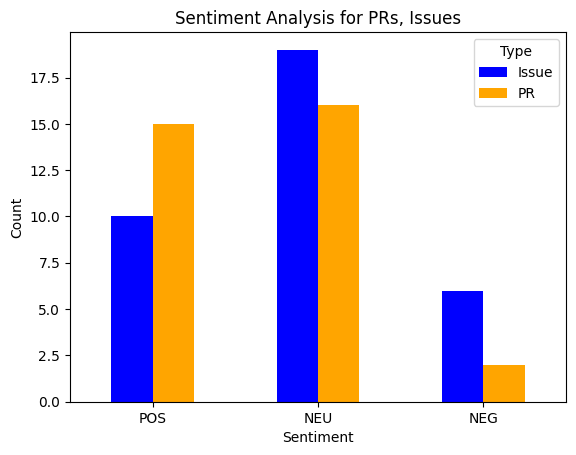

In [ ]:
visualizer.post_analysis_visualization(post_sentiment_results)

In [ ]:
visualizer.show_graph(graph_path)

In [ ]:
def calculate_user_word_contribution(user_interaction_df):
    """
    Calculate the total number of words contributed by each user in the discussion.

    Parameters:
        user_interaction_df (pd.DataFrame): DataFrame containing user interactions.

    Returns:
        pd.DataFrame: A DataFrame with each user's total word count and their percentage contribution.
    """
    import pandas as pd

    # Initialize a dictionary to store word counts for each user
    word_count = {}

    # Iterate through each row in the DataFrame
    for _, row in user_interaction_df.iterrows():
        sender = row['from']

        # Extract messages from positive, neutral, and negative columns
        messages = []
        if row['positive']:
            messages.extend([msg['message'] for msg in row['positive'] if 'message' in msg])
        if row['neutral']:
            messages.extend([msg['message'] for msg in row['neutral'] if 'message' in msg])
        if row['negative']:
            messages.extend([msg['message'] for msg in row['negative'] if 'message' in msg])

        # Count words in all messages
        num_words = sum(len(message.split()) for message in messages)
        word_count[sender] = word_count.get(sender, 0) + num_words

    # Convert the dictionary to a DataFrame
    total_words = sum(word_count.values())
    word_count_df = pd.DataFrame([
        {
            'user': user,
            'word_count': count,
            'percentage_contribution': (count / total_words) * 100
        }
        for user, count in word_count.items()
    ])

    # Sort the DataFrame by word count in descending order
    word_count_df = word_count_df.sort_values(by='word_count', ascending=False).reset_index(drop=True)
    print(f"Total words in the discussion: {total_words}")
    return word_count_df



def analyze_user_sentiment(user_interaction_df, target_user):
    """
    Analyze and print the sentiment-related statistics for a specific user, including messages sent/received
    and sentiments given/received.

    Parameters:
        user_interaction_df (pd.DataFrame): DataFrame containing user interactions.
        target_user (str): The user to analyze.

    Returns:
        None: The function prints the results directly.
    """
    # Total messages in the dataset (sum lengths of positive, neutral, and negative lists for all rows)
    total_messages = sum(
        len(row['positive']) + len(row['neutral']) + len(row['negative']) for _, row in user_interaction_df.iterrows()
    )

    # Total messages sent and received by the target user
    messages_sent = sum(
        len(row['positive']) + len(row['neutral']) + len(row['negative'])
        for _, row in user_interaction_df[user_interaction_df['from'] == target_user].iterrows()
    )
    messages_received = sum(
        len(row['positive']) + len(row['neutral']) + len(row['negative'])
        for _, row in user_interaction_df[user_interaction_df['to'] == target_user].iterrows()
    )

    # Contribution to total messages (%)
    sent_message_contribution = (messages_sent / total_messages) * 100 if total_messages > 0 else 0
    received_message_contribution = (messages_received / total_messages) * 100 if total_messages > 0 else 0

    # Total sentiments (given and received) in the dataset
    total_sentiments_given = sum(len(row) for row in user_interaction_df['positive']) + \
                             sum(len(row) for row in user_interaction_df['neutral']) + \
                             sum(len(row) for row in user_interaction_df['negative'])

    # Sentiments given by the target user
    pos_given = sum(len(row) for row in user_interaction_df[user_interaction_df['from'] == target_user]['positive'])
    neu_given = sum(len(row) for row in user_interaction_df[user_interaction_df['from'] == target_user]['neutral'])
    neg_given = sum(len(row) for row in user_interaction_df[user_interaction_df['from'] == target_user]['negative'])
    sentiments_given = pos_given + neu_given + neg_given

    # Sentiments received by the target user
    pos_received = sum(len(row) for row in user_interaction_df[user_interaction_df['to'] == target_user]['positive'])
    neu_received = sum(len(row) for row in user_interaction_df[user_interaction_df['to'] == target_user]['neutral'])
    neg_received = sum(len(row) for row in user_interaction_df[user_interaction_df['to'] == target_user]['negative'])
    sentiments_received = pos_received + neu_received + neg_received

    # Total sentiments (POS, NEU, NEG)
    total_pos = sum(len(row) for row in user_interaction_df['positive'])
    total_neu = sum(len(row) for row in user_interaction_df['neutral'])
    total_neg = sum(len(row) for row in user_interaction_df['negative'])

    # Percentage contributions
    pos_given_contribution = (pos_given / total_pos) * 100 if total_pos > 0 else 0
    neu_given_contribution = (neu_given / total_neu) * 100 if total_neu > 0 else 0
    neg_given_contribution = (neg_given / total_neg) * 100 if total_neg > 0 else 0

    pos_received_contribution = (pos_received / total_pos) * 100 if total_pos > 0 else 0
    neu_received_contribution = (neu_received / total_neu) * 100 if total_neu > 0 else 0
    neg_received_contribution = (neg_received / total_neg) * 100 if total_neg > 0 else 0

    # Print results
    print(f"User: {target_user}")
    print("-------------------------------------------")
    print(f"Total messages in dataset: {total_messages}")
    print(f"Total sentiments in dataset: {total_sentiments_given}")
    print(f"Total POS sentiments in dataset: {total_pos}")
    print(f"Total NEU sentiments in dataset: {total_neu}")
    print(f"Total NEG sentiments in dataset: {total_neg}")
    print("-------------------------------------------")
    print(f"Messages sent by {target_user}: {messages_sent} ({sent_message_contribution:.2f}%)")
    print(f"Messages received by {target_user}: {messages_received} ({received_message_contribution:.2f}%)")
    print(f"Total sentiments given by {target_user}: {sentiments_given}")
    print(f"  POS given by {target_user}: {pos_given} ({pos_given_contribution:.2f}%)")
    print(f"  NEU given by {target_user}: {neu_given} ({neu_given_contribution:.2f}%)")
    print(f"  NEG given by {target_user}: {neg_given} ({neg_given_contribution:.2f}%)")
    print(f"Total sentiments received by {target_user}: {sentiments_received}")
    print(f"  POS received by {target_user}: {pos_received} ({pos_received_contribution:.2f}%)")
    print(f"  NEU received by {target_user}: {neu_received} ({neu_received_contribution:.2f}%)")
    print(f"  NEG received by {target_user}: {neg_received} ({neg_received_contribution:.2f}%)")


In [ ]:
word_contribution = calculate_user_word_contribution(user_interactions)
word_contribution

Total words in the discussion: 15794


,user,word_count,percentage_contribution
0,Lasse Collin,6836,43.282259
1,Jia Tan,4183,26.484741
2,Hans Jansen,1115,7.059643
3,Kelvin Lee,460,2.912498
4,Xi Ruoyao,435,2.754210
5,Ricky Tigg,308,1.950108
6,Janne Enberg,243,1.538559
7,Chenxi Mao,216,1.367608
8,David Chalmers,130,0.823097
9,Michael Catanzaro,129,0.816766


In [ ]:
analyze_user_sentiment(user_interactions, 'Jia Tan')

User: Jia Tan
-------------------------------------------
Total messages in dataset: 200
Total sentiments in dataset: 200
Total POS sentiments in dataset: 77
Total NEU sentiments in dataset: 76
Total NEG sentiments in dataset: 47
-------------------------------------------
Messages sent by Jia Tan: 43 (21.50%)
Messages received by Jia Tan: 37 (18.50%)
Total sentiments given by Jia Tan: 43
  POS given by Jia Tan: 23 (29.87%)
  NEU given by Jia Tan: 18 (23.68%)
  NEG given by Jia Tan: 2 (4.26%)
Total sentiments received by Jia Tan: 37
  POS received by Jia Tan: 13 (16.88%)
  NEU received by Jia Tan: 14 (18.42%)
  NEG received by Jia Tan: 10 (21.28%)


In [ ]:
analyze_user_sentiment(user_interactions, 'Lasse Collin')

User: Lasse Collin
-------------------------------------------
Total messages in dataset: 200
Total sentiments in dataset: 200
Total POS sentiments in dataset: 77
Total NEU sentiments in dataset: 76
Total NEG sentiments in dataset: 47
-------------------------------------------
Messages sent by Lasse Collin: 49 (24.50%)
Messages received by Lasse Collin: 35 (17.50%)
Total sentiments given by Lasse Collin: 49
  POS given by Lasse Collin: 17 (22.08%)
  NEU given by Lasse Collin: 23 (30.26%)
  NEG given by Lasse Collin: 9 (19.15%)
Total sentiments received by Lasse Collin: 35
  POS received by Lasse Collin: 17 (22.08%)
  NEU received by Lasse Collin: 12 (15.79%)
  NEG received by Lasse Collin: 6 (12.77%)


In [ ]:
analyze_user_sentiment(user_interactions, 'Hans Jansen')

User: Hans Jansen
-------------------------------------------
Total messages in dataset: 200
Total sentiments in dataset: 200
Total POS sentiments in dataset: 77
Total NEU sentiments in dataset: 76
Total NEG sentiments in dataset: 47
-------------------------------------------
Messages sent by Hans Jansen: 13 (6.50%)
Messages received by Hans Jansen: 10 (5.00%)
Total sentiments given by Hans Jansen: 13
  POS given by Hans Jansen: 9 (11.69%)
  NEU given by Hans Jansen: 3 (3.95%)
  NEG given by Hans Jansen: 1 (2.13%)
Total sentiments received by Hans Jansen: 10
  POS received by Hans Jansen: 8 (10.39%)
  NEU received by Hans Jansen: 1 (1.32%)
  NEG received by Hans Jansen: 1 (2.13%)


In [ ]:
pd.read_csv('tukaani-project_xz/individual_issue_pr/pr_64.csv')

,event,from,created_at,body,to
0,thread_started,hansjans162,2023-09-25T19:53:53Z,Added an implementation for crc32 that makes u...,['hansjans162']
1,commented,JiaT75,2023-09-26T15:00:43Z,"Hello!\n\nThanks for the PR, this is something...",['hansjans162']
2,commented,hansjans162,2023-09-26T20:40:38Z,\nI tested the difference that using GCC and C...,['JiaT75']
3,commented,hansjans162,2023-09-29T19:16:00Z,I have made all of the changes listed above. I...,['JiaT75']
4,commented,Larhzu,2023-10-05T19:58:55Z,I'm sorry for the delay. Neither Jia or I have...,['hansjans162']
5,commented,hansjans162,2023-10-07T12:05:16Z,I've started work on the changes. Don't worry ...,['Larhzu']
6,commented,hansjans162,2023-10-12T19:43:18Z,\nI updated the PR with the squashing and comm...,['Larhzu']
7,commented,JiaT75,2023-10-13T12:52:54Z,\nThanks for the updates!\n\n\nThanks for benc...,['hansjans162']
8,commented,Larhzu,2023-10-13T16:04:28Z,I'm glad this has been merged. Thanks!\n\nA fe...,['JiaT75']
9,commented,JiaT75,2023-10-18T16:13:00Z,@hansjans162 We committed some changes to reor...,hansjans162


In [ ]:
df = pd.read_csv('tukaani-project_xz/deleted_user_interactions/removed_empty_from_to.csv')

In [ ]:
df.shape

(51, 5)